# TravelSafe: Data-Driven Analysis of International Travel Safety

**Team Members:**
- Sylvan Wang (USC ID: 6176724527)
- Ningjun Li (USC ID: 5528989772)

## Project Overview

This notebook analyzes international travel safety by combining:
1. **REST Countries API** - Country demographics and geographic data
2. **Wikipedia** - Homicide rate data (web scraping)
3. **US State Department** - Travel advisory levels (from country_safety.json)

We will explore patterns, correlations, and create visualizations to understand global travel safety indicators.


## 1. Data Collection


### 0. Install Required Packages


In [66]:
# Install all required packages
%pip install requests pandas numpy matplotlib seaborn beautifulsoup4 lxml html5lib -q

print("✓ All required packages installed successfully!")


Note: you may need to restart the kernel to use updated packages.
✓ All required packages installed successfully!


### 1.1 Import Libraries


In [67]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from html import unescape
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('dark_background')
sns.set_palette("husl")
%matplotlib inline


### 1.2 Fetch REST Countries Data


In [68]:
REST_COUNTRIES_URL = (
    "https://restcountries.com/v3.1/all"
    "?fields=name,cca2,region,subregion,population,capital,languages,currencies"
)

print("Fetching REST Countries data...")
resp = requests.get(REST_COUNTRIES_URL, timeout=20)
resp.raise_for_status()
countries_data = resp.json()

# Convert to DataFrame
countries_list = []
for item in countries_data:
    code = item.get("cca2")
    if not code:
        continue
    name = item.get("name", {}).get("common", "")
    countries_list.append({
        "code": code.upper(),
        "name": name,
        "region": item.get("region", ""),
        "subregion": item.get("subregion", ""),
        "population": item.get("population"),
        "capital": (item.get("capital") or ["N/A"])[0],
        "languages": ", ".join(list(item.get("languages", {}).values())[:3]) if item.get("languages") else "N/A",
        "currencies": ", ".join([c["name"] for c in list(item.get("currencies", {}).values())[:2]]) if item.get("currencies") else "N/A"
    })

df_countries = pd.DataFrame(countries_list)
print(f"✓ Loaded {len(df_countries)} countries from REST Countries API")
print(f"\nSample data:")
df_countries.head()


Fetching REST Countries data...
✓ Loaded 250 countries from REST Countries API

Sample data:


,code,name,region,subregion,population,capital,languages,currencies
0,SY,Syria,Asia,Western Asia,25620000,Damascus,Arabic,Syrian pound
1,NZ,New Zealand,Oceania,Australia and New Zealand,5324700,Wellington,"English, Māori, New Zealand Sign Language",New Zealand dollar
2,BN,Brunei,Asia,South-Eastern Asia,455500,Bandar Seri Begawan,Malay,"Brunei dollar, Singapore dollar"
3,IO,British Indian Ocean Territory,Africa,Eastern Africa,0,Diego Garcia,English,United States dollar
4,KE,Kenya,Africa,Eastern Africa,53330978,Nairobi,"English, Swahili",Kenyan shilling


### 1.3 Scrape Homicide Rate Data from Wikipedia


In [69]:
WIKIPEDIA_URL = "https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate"

print("Scraping homicide rate data from Wikipedia...")
df_homicide = None

# Set headers to avoid 403 Forbidden error
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    # Method 1: First fetch HTML with requests, then parse with pandas
    print("Fetching HTML content...")
    resp = requests.get(WIKIPEDIA_URL, timeout=30, headers=headers)
    resp.raise_for_status()
    print(f"✓ HTML fetched successfully ({len(resp.text)} characters)")
    
    # Parse all tables from the HTML
    print("Parsing tables from HTML...")
    tables = pd.read_html(resp.text)
    print(f"✓ Found {len(tables)} tables")
    
    # Find the table with homicide rate data (should have many rows and contain country/rate columns)
    for idx, table in enumerate(tables):
        cols_str = str(table.columns).lower()
        # Look for tables with country and rate columns, and should have many rows
        if len(table) > 50 and ('country' in cols_str or 'territory' in cols_str) and ('rate' in cols_str or 'homicide' in cols_str):
            df_homicide = table
            print(f"✓ Found homicide rate table (table #{idx+1}) with {len(df_homicide)} rows")
            break
    
    # If not found by criteria, try the largest table
    if df_homicide is None and len(tables) > 0:
        largest_table = max(tables, key=len)
        if len(largest_table) > 50:  # Should have many countries
            df_homicide = largest_table
            print(f"Using largest table as fallback (table with {len(df_homicide)} rows)")
    
    if df_homicide is not None and len(df_homicide) > 0:
        print(f"\n✓ Successfully loaded {len(df_homicide)} rows")
        print(f"\nColumns: {list(df_homicide.columns)}")
        print(f"\nFirst few rows:")
        display(df_homicide.head(10))
    else:
        raise ValueError("No valid tables found")
    
except Exception as e:
    print(f"Error: {e}")
    print("\nTrying alternative method with BeautifulSoup...")
    
    try:
        resp = requests.get(WIKIPEDIA_URL, timeout=30, headers=headers)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, 'html.parser')
        
        # Find all wikitable elements
        tables_html = soup.find_all('table', class_='wikitable')
        print(f"Found {len(tables_html)} wikitable elements")
        
        # Try each table
        for idx, table_html in enumerate(tables_html):
            try:
                temp_df = pd.read_html(str(table_html))[0]
                cols_str = str(temp_df.columns).lower()
                if len(temp_df) > 50 and ('country' in cols_str or 'territory' in cols_str):
                    df_homicide = temp_df
                    print(f"✓ Found homicide rate table (wikitable #{idx+1}) with {len(df_homicide)} rows")
                    break
            except:
                continue
        
        if df_homicide is not None and len(df_homicide) > 0:
            print(f"\nColumns: {list(df_homicide.columns)}")
            display(df_homicide.head(10))
        else:
            raise ValueError("No suitable wikitable found")
            
    except Exception as e2:
        print(f"Error with BeautifulSoup method: {e2}")
        import traceback
        traceback.print_exc()
        print("Creating empty DataFrame as fallback...")
        df_homicide = pd.DataFrame()

# Ensure df_homicide is always defined
if df_homicide is None or (isinstance(df_homicide, pd.DataFrame) and len(df_homicide) == 0):
    df_homicide = pd.DataFrame()
    print("\n⚠️ Warning: Could not scrape homicide rate data. Using empty DataFrame.")
    print("The analysis will continue but without homicide rate data.")
else:
    print(f"\n✅ Successfully loaded homicide rate data for {len(df_homicide)} countries/territories")


Scraping homicide rate data from Wikipedia...
Fetching HTML content...
✓ HTML fetched successfully (329479 characters)
Parsing tables from HTML...
✓ Found 4 tables
Using largest table as fallback (table with 204 rows)

✓ Successfully loaded 204 rows

Columns: ['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion']

First few rows:


,Location,Rate,Count,Year,Region,Subregion
0,Afghanistan *,4.022,1613,2021,Asia,Southern Asia
1,Albania *,1.387,39,2023,Europe,Southern Europe
2,Algeria,1.161,536,2023,Africa,Northern Africa
3,American Samoa,0.000,0,2019,Oceania,Polynesia
4,Andorra,2.574,2,2020,Europe,Southern Europe
5,Angola,4.102,1196,2016,Africa,Sub-Saharan Africa
6,Anguilla,28.328,4,2014,Americas,Latin America and the Caribbean
7,Antigua and Barbuda *,10.665,10,2022,Americas,Latin America and the Caribbean
8,Argentina *,4.309,1961,2022,Americas,Latin America and the Caribbean
9,Armenia *,2.186,61,2021,Asia,Western Asia



✅ Successfully loaded homicide rate data for 204 countries/territories


### 1.4 Clean and Standardize Homicide Rate Data


In [70]:
# Clean homicide rate data
# Check if df_homicide exists and is not empty
if 'df_homicide' not in globals() or df_homicide is None or len(df_homicide) == 0:
    print("Warning: df_homicide is empty or not defined. Creating empty DataFrame.")
    df_homicide_clean = pd.DataFrame(columns=['country_clean', 'homicide_rate'])
else:
    # The exact column names may vary, so we'll need to inspect and adjust
    print("Original columns:")
    print(df_homicide.columns.tolist())

    # Standardize column names (adjust based on actual Wikipedia table structure)
    # Common patterns: Country/Territory, Rate, Year, etc.
    if len(df_homicide.columns) > 0 and 'Country' in str(df_homicide.columns[0]):
        df_homicide = df_homicide.rename(columns={df_homicide.columns[0]: 'country'})

    # Find rate column (usually contains numbers and may have "Rate" or "per 100,000")
    rate_col = None
    for col in df_homicide.columns:
        if 'rate' in str(col).lower() or 'per 100' in str(col).lower() or df_homicide[col].dtype in [np.float64, np.int64]:
            if df_homicide[col].dtype in [np.float64, np.int64] or any(isinstance(x, (int, float)) for x in df_homicide[col].dropna().head(5) if pd.notna(x)):
                rate_col = col
                break

    if rate_col:
        df_homicide['homicide_rate'] = pd.to_numeric(df_homicide[rate_col], errors='coerce')
    else:
        # Fallback: use first numeric column
        numeric_cols = df_homicide.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            df_homicide['homicide_rate'] = df_homicide[numeric_cols[0]]
        else:
            df_homicide['homicide_rate'] = np.nan

    # Clean country names
    if len(df_homicide.columns) > 0:
        df_homicide['country_clean'] = df_homicide.iloc[:, 0].astype(str).str.strip()
    else:
        df_homicide['country_clean'] = ''

    # Remove rows with missing homicide rate
    df_homicide_clean = df_homicide[df_homicide['homicide_rate'].notna()].copy()

    print(f"\n✓ Cleaned data: {len(df_homicide_clean)} countries with valid homicide rates")
    if len(df_homicide_clean) > 0:
        print(f"\nSample cleaned data:")
        display(df_homicide_clean[['country_clean', 'homicide_rate']].head(10))
    else:
        print("No valid homicide rate data found.")


Original columns:
['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion']

✓ Cleaned data: 204 countries with valid homicide rates

Sample cleaned data:


,country_clean,homicide_rate
0,Afghanistan *,4.022
1,Albania *,1.387
2,Algeria,1.161
3,American Samoa,0.000
4,Andorra,2.574
5,Angola,4.102
6,Anguilla,28.328
7,Antigua and Barbuda *,10.665
8,Argentina *,4.309
9,Armenia *,2.186


### 1.5 Data Quality Check and Summary


In [71]:
# Analyze the scraped homicide rate data
print("=" * 60)
print("HOMICIDE RATE DATA ANALYSIS")
print("=" * 60)

if 'df_homicide' in globals() and df_homicide is not None and len(df_homicide) > 0:
    print(f"\n📊 Dataset Overview:")
    print(f"   Total records: {len(df_homicide)}")
    print(f"   Columns: {list(df_homicide.columns)}")
    
    # Check data types
    print(f"\n📋 Data Types:")
    print(df_homicide.dtypes)
    
    # Check for missing values
    print(f"\n🔍 Missing Values:")
    missing = df_homicide.isnull().sum()
    print(missing[missing > 0])
    
    # Basic statistics for Rate column
    if 'Rate' in df_homicide.columns:
        print(f"\n📈 Homicide Rate Statistics (per 100,000):")
        print(df_homicide['Rate'].describe())
        
        # Check year distribution
        if 'Year' in df_homicide.columns:
            print(f"\n📅 Year Distribution:")
            print(df_homicide['Year'].value_counts().head(10))
        
        # Regional distribution
        if 'Region' in df_homicide.columns:
            print(f"\n🌍 Regional Distribution:")
            region_counts = df_homicide['Region'].value_counts()
            print(region_counts)
            
            print(f"\n📊 Average Homicide Rate by Region:")
            region_avg = df_homicide.groupby('Region')['Rate'].agg(['mean', 'median', 'count']).round(2)
            region_avg.columns = ['Mean Rate', 'Median Rate', 'Count']
            print(region_avg.sort_values('Mean Rate', ascending=False))
    
    # Top and bottom countries
    if 'Rate' in df_homicide.columns and 'Location' in df_homicide.columns:
        print(f"\n🔝 Top 10 Countries by Homicide Rate:")
        top_10 = df_homicide.nlargest(10, 'Rate')[['Location', 'Rate', 'Region']]
        print(top_10.to_string(index=False))
        
        print(f"\n🔻 Bottom 10 Countries by Homicide Rate:")
        bottom_10 = df_homicide.nsmallest(10, 'Rate')[['Location', 'Rate', 'Region']]
        print(bottom_10.to_string(index=False))
    
    # Display sample data
    print(f"\n📋 Sample Data (First 5 rows):")
    display(df_homicide.head())
    
else:
    print("⚠️ No homicide rate data available for analysis.")


HOMICIDE RATE DATA ANALYSIS

📊 Dataset Overview:
   Total records: 204
   Columns: ['Location', 'Rate', 'Count', 'Year', 'Region', 'Subregion', 'homicide_rate', 'country_clean']

📋 Data Types:
Location          object
Rate             float64
Count              int64
Year               int64
Region            object
Subregion         object
homicide_rate    float64
country_clean     object
dtype: object

🔍 Missing Values:
Series([], dtype: int64)

📈 Homicide Rate Statistics (per 100,000):
count    204.000000
mean       7.193922
std       11.291211
min        0.000000
25%        0.986500
50%        2.601000
75%        7.195500
max       76.582000
Name: Rate, dtype: float64

📅 Year Distribution:
Year
2023    55
2022    45
2021    20
2020    18
2019    13
2012     9
2009     7
2016     6
2011     6
2013     4
Name: count, dtype: int64

🌍 Regional Distribution:
Region
Americas    51
Asia        49
Europe      49
Africa      37
Oceania     18
Name: count, dtype: int64

📊 Average Homicide Ra

,Location,Rate,Count,Year,Region,Subregion,homicide_rate,country_clean
0,Afghanistan *,4.022,1613,2021,Asia,Southern Asia,4.022,Afghanistan *
1,Albania *,1.387,39,2023,Europe,Southern Europe,1.387,Albania *
2,Algeria,1.161,536,2023,Africa,Northern Africa,1.161,Algeria
3,American Samoa,0.000,0,2019,Oceania,Polynesia,0.000,American Samoa
4,Andorra,2.574,2,2020,Europe,Southern Europe,2.574,Andorra


### 1.5 Load Travel Safety Data (from build_country_safety.py output)


In [72]:
# Load the country_safety.json file generated by build_country_safety.py
with open('country_safety.json', 'r', encoding='utf-8') as f:
    safety_data = json.load(f)

# Convert to DataFrame
safety_list = []
for code, data in safety_data.items():
    risk_scores = data.get('risk_scores', {})
    safety_list.append({
        'code': code,
        'name': data.get('name', ''),
        'region': data.get('region', ''),
        'overall_risk': data.get('overall_risk', 'unknown'),
        'crime_score': risk_scores.get('crime', 3),
        'political_score': risk_scores.get('political', 3),
        'health_score': risk_scores.get('health', 3),
        'natural_disaster_score': risk_scores.get('natural_disaster', 3),
        'is_core_country': data.get('is_core_country', False)
    })

df_safety = pd.DataFrame(safety_list)
print(f"✓ Loaded safety data for {len(df_safety)} countries")
df_safety.head()


✓ Loaded safety data for 250 countries


,code,name,region,overall_risk,crime_score,political_score,health_score,natural_disaster_score,is_core_country
0,SY,Syria,Asia,high,4,4,3,3,False
1,NZ,New Zealand,Oceania,low,2,2,2,2,True
2,BN,Brunei,Asia,low,2,2,2,2,False
3,IO,British Indian Ocean Territory,Africa,unknown,3,3,3,3,False
4,KE,Kenya,Africa,medium,3,3,2,3,False


### 2.1 Merged Dataset Analysis


In [73]:
# Analyze the merged dataset
print("=" * 60)
print("MERGED DATASET ANALYSIS")
print("=" * 60)

if 'df_final' in globals() and df_final is not None and len(df_final) > 0:
    print(f"\n📊 Dataset Overview:")
    print(f"   Total countries: {len(df_final)}")
    print(f"   Countries with homicide rate data: {df_final['homicide_rate'].notna().sum()}")
    print(f"   Countries with safety scores: {df_final['crime_score'].notna().sum()}")
    print(f"   Coverage: {df_final['homicide_rate'].notna().sum() / len(df_final) * 100:.1f}%")
    
    # Data completeness
    print(f"\n📋 Data Completeness:")
    completeness = {
        'Homicide Rate': df_final['homicide_rate'].notna().sum(),
        'Crime Score': df_final['crime_score'].notna().sum(),
        'Political Score': df_final['political_score'].notna().sum(),
        'Health Score': df_final['health_score'].notna().sum(),
        'Natural Disaster Score': df_final['natural_disaster_score'].notna().sum(),
        'Population': df_final['population'].notna().sum(),
        'Region': df_final['region'].notna().sum()
    }
    for key, value in completeness.items():
        pct = value / len(df_final) * 100
        print(f"   {key}: {value}/{len(df_final)} ({pct:.1f}%)")
    
    # Overall risk distribution
    print(f"\n⚠️ Overall Risk Distribution:")
    risk_dist = df_final['overall_risk'].value_counts()
    for risk, count in risk_dist.items():
        pct = count / len(df_final) * 100
        print(f"   {risk}: {count} countries ({pct:.1f}%)")
    
    # Regional coverage
    print(f"\n🌍 Regional Coverage:")
    regional_coverage = df_final.groupby('region').agg({
        'homicide_rate': lambda x: x.notna().sum(),
        'code': 'count'
    })
    regional_coverage.columns = ['With Homicide Data', 'Total Countries']
    regional_coverage['Coverage %'] = (regional_coverage['With Homicide Data'] / regional_coverage['Total Countries'] * 100).round(1)
    print(regional_coverage.sort_values('Coverage %', ascending=False))
    
    # Countries with both homicide and safety data
    df_with_both = df_final[(df_final['homicide_rate'].notna()) & (df_final['crime_score'].notna())]
    print(f"\n✅ Countries with Both Homicide Rate and Safety Scores: {len(df_with_both)}")
    
    if len(df_with_both) > 0:
        print(f"\n📈 Statistics for Countries with Complete Data:")
        print(f"   Average Homicide Rate: {df_with_both['homicide_rate'].mean():.2f} per 100,000")
        print(f"   Average Crime Score: {df_with_both['crime_score'].mean():.2f}")
        print(f"   Average Political Score: {df_with_both['political_score'].mean():.2f}")
        
        # Correlation preview
        if len(df_with_both) > 10:
            corr_homicide_crime = df_with_both['homicide_rate'].corr(df_with_both['crime_score'])
            print(f"\n🔗 Correlation (Homicide Rate vs Crime Score): {corr_homicide_crime:.3f}")
            if abs(corr_homicide_crime) > 0.5:
                print("   → Strong correlation")
            elif abs(corr_homicide_crime) > 0.3:
                print("   → Moderate correlation")
            else:
                print("   → Weak correlation")
    
    # Sample of merged data
    print(f"\n📋 Sample Merged Data (First 5 rows with homicide data):")
    sample = df_final[df_final['homicide_rate'].notna()].head()
    display(sample[['name', 'region', 'homicide_rate', 'crime_score', 'political_score', 'overall_risk']])
    
else:
    print("⚠️ Merged dataset not available. Please run the data integration cell first.")


MERGED DATASET ANALYSIS

📊 Dataset Overview:
   Total countries: 252
   Countries with homicide rate data: 76
   Countries with safety scores: 252
   Coverage: 30.2%

📋 Data Completeness:
   Homicide Rate: 76/252 (30.2%)
   Crime Score: 252/252 (100.0%)
   Political Score: 252/252 (100.0%)
   Health Score: 252/252 (100.0%)
   Natural Disaster Score: 252/252 (100.0%)
   Population: 252/252 (100.0%)
   Region: 252/252 (100.0%)

⚠️ Overall Risk Distribution:
   medium: 82 countries (32.5%)
   low: 81 countries (32.1%)
   high: 45 countries (17.9%)
   unknown: 44 countries (17.5%)

🌍 Regional Coverage:
           With Homicide Data  Total Countries  Coverage %
region                                                    
Oceania                    13               27        48.1
Africa                     21               59        35.6
Americas                   19               56        33.9
Europe                     12               53        22.6
Asia                       11           

,name,region,homicide_rate,crime_score,political_score,overall_risk
0,Syria,Asia,2.073,4,4,high
2,Brunei,Asia,0.486,2,2,low
5,Palau,Oceania,11.195,2,2,low
9,Turks and Caicos Islands,Americas,76.582,3,3,medium
12,South Sudan,Africa,14.054,4,4,high


## 2. Data Integration and Cleaning


In [74]:
# Merge datasets
# First, merge countries with safety data (by code)
df_merged = df_countries.merge(df_safety, on='code', how='left', suffixes=('', '_safety'))

# Then merge with homicide rate data (by country name)
# Need to handle name mismatches
def normalize_country_name(name):
    """Normalize country names for matching"""
    if pd.isna(name):
        return ""
    name = str(name).strip().lower()
    # Remove common suffixes
    name = re.sub(r'\s*\(.*?\)', '', name)  # Remove parentheses
    name = re.sub(r'^the\s+', '', name)  # Remove "the"
    return name

df_merged['name_normalized'] = df_merged['name'].apply(normalize_country_name)
df_homicide_clean['country_normalized'] = df_homicide_clean['country_clean'].apply(normalize_country_name)

# Merge on normalized names
df_final = df_merged.merge(
    df_homicide_clean[['country_normalized', 'homicide_rate']],
    left_on='name_normalized',
    right_on='country_normalized',
    how='left'
)

print(f"✓ Merged dataset: {len(df_final)} countries")
print(f"  - Countries with homicide rate: {df_final['homicide_rate'].notna().sum()}")
print(f"  - Countries with safety scores: {df_final['crime_score'].notna().sum()}")

# Display summary statistics
print("\nDataset summary:")
df_final.info()


✓ Merged dataset: 252 countries
  - Countries with homicide rate: 76
  - Countries with safety scores: 252

Dataset summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   code                    252 non-null    object 
 1   name                    252 non-null    object 
 2   region                  252 non-null    object 
 3   subregion               252 non-null    object 
 4   population              252 non-null    int64  
 5   capital                 252 non-null    object 
 6   languages               252 non-null    object 
 7   currencies              252 non-null    object 
 8   name_safety             252 non-null    object 
 9   region_safety           252 non-null    object 
 10  overall_risk            252 non-null    object 
 11  crime_score             252 non-null    int64  
 12  political_score        

## 3. Data Analysis


### 3.1 Descriptive Statistics


In [75]:
print("=== Descriptive Statistics ===")
print("\nHomicide Rate Statistics:")
print(df_final['homicide_rate'].describe())

print("\n\nSafety Score Statistics:")
safety_cols = ['crime_score', 'political_score', 'health_score', 'natural_disaster_score']
print(df_final[safety_cols].describe())

print("\n\nOverall Risk Distribution:")
print(df_final['overall_risk'].value_counts())


=== Descriptive Statistics ===

Homicide Rate Statistics:
count    76.000000
mean      7.573895
std      11.318845
min       0.000000
25%       1.540250
50%       3.859000
75%       9.353750
max      76.582000
Name: homicide_rate, dtype: float64


Safety Score Statistics:
       crime_score  political_score  health_score  natural_disaster_score
count   252.000000       252.000000    252.000000              252.000000
mean      2.857143         2.857143      2.353175                2.678571
std       0.693904         0.693904      0.478908                0.467954
min       2.000000         2.000000      2.000000                2.000000
25%       2.000000         2.000000      2.000000                2.000000
50%       3.000000         3.000000      2.000000                3.000000
75%       3.000000         3.000000      3.000000                3.000000
max       4.000000         4.000000      3.000000                3.000000


Overall Risk Distribution:
overall_risk
medium     82
low  

### 3.2 Correlation Analysis


In [76]:
# Calculate correlations
numeric_cols = ['population', 'homicide_rate', 'crime_score', 'political_score', 
                'health_score', 'natural_disaster_score']
corr_data = df_final[numeric_cols].corr()

print("Correlation Matrix:")
print(corr_data.round(3))


Correlation Matrix:
                        population  homicide_rate  crime_score  \
population                   1.000         -0.131        0.099   
homicide_rate               -0.131          1.000       -0.009   
crime_score                  0.099         -0.009        1.000   
political_score              0.099         -0.009        1.000   
health_score                -0.032         -0.089        0.692   
natural_disaster_score       0.119          0.022        0.852   

                        political_score  health_score  natural_disaster_score  
population                        0.099        -0.032                   0.119  
homicide_rate                    -0.009        -0.089                   0.022  
crime_score                       1.000         0.692                   0.852  
political_score                   1.000         0.692                   0.852  
health_score                      0.692         1.000                   0.509  
natural_disaster_score            0.8

### 3.3 Regional Analysis


In [77]:
# Analyze by region
regional_stats = df_final.groupby('region').agg({
    'homicide_rate': ['mean', 'median', 'std'],
    'crime_score': 'mean',
    'political_score': 'mean',
    'population': 'sum'
}).round(2)

print("Regional Safety Statistics:")
print(regional_stats)


Regional Safety Statistics:
          homicide_rate               crime_score political_score  population
                   mean median    std        mean            mean         sum
region                                                                       
Africa             5.77   4.39   4.21        3.20            3.20  1462464411
Americas          18.20  13.30  18.09        2.79            2.79  1042579783
Antarctic           NaN    NaN    NaN        3.00            3.00        1700
Asia               4.11   2.25   4.58        2.96            2.96  4816969552
Europe             1.39   1.00   1.48        2.57            2.57   741657922
Oceania            3.60   3.49   3.18        2.59            2.59    48059678


## 4. Visualizations


### 4.1 Top 10 and Bottom 10 Countries by Homicide Rate


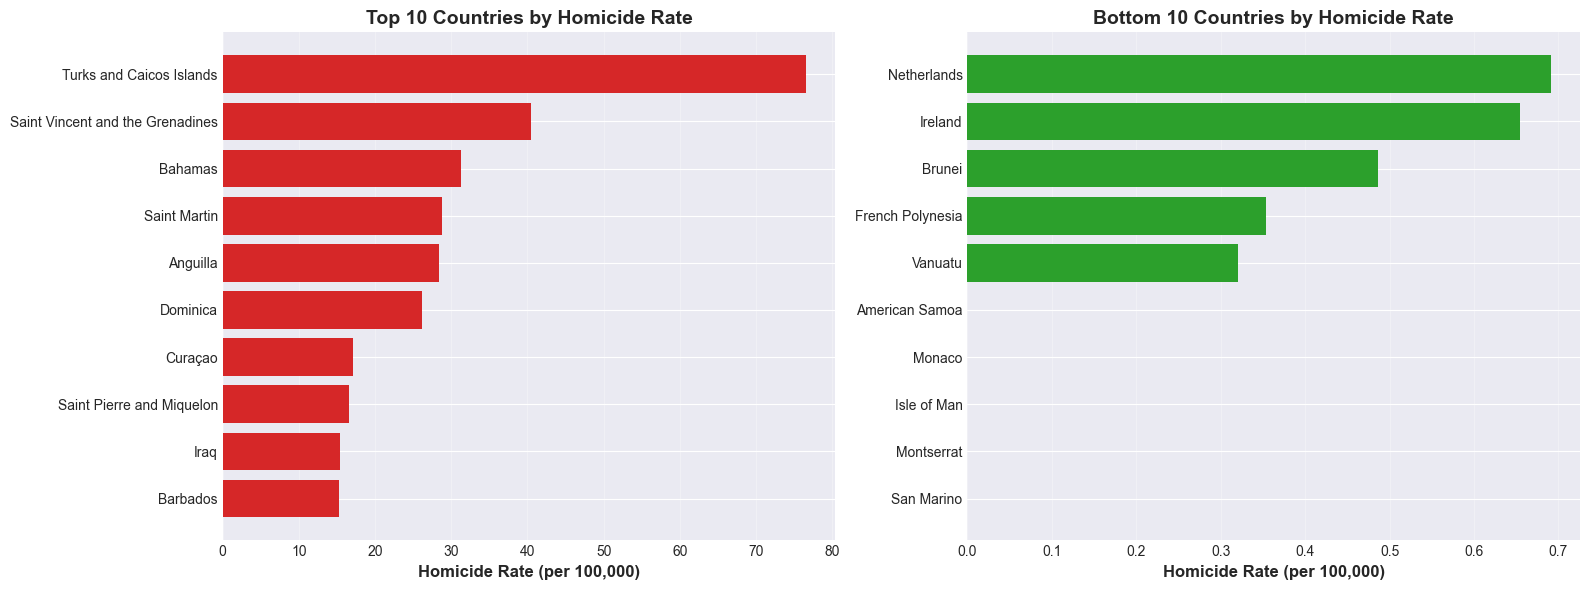


Top 10 Highest Homicide Rates:
                            name   region  homicide_rate
        Turks and Caicos Islands Americas         76.582
Saint Vincent and the Grenadines Americas         40.405
                         Bahamas Americas         31.221
                    Saint Martin Americas         28.727
                        Anguilla Americas         28.328
                        Dominica Americas         26.121
                         Curaçao Americas         17.092
       Saint Pierre and Miquelon Americas         16.518
                            Iraq     Asia         15.397
                        Barbados Americas         15.268


Bottom 10 Lowest Homicide Rates:
            name   region  homicide_rate
     Netherlands   Europe          0.691
         Ireland   Europe          0.654
          Brunei     Asia          0.486
French Polynesia  Oceania          0.354
         Vanuatu  Oceania          0.321
  American Samoa  Oceania          0.000
          Monaco   

In [78]:
# Filter countries with valid homicide rate data
df_with_homicide = df_final[df_final['homicide_rate'].notna()].copy()
df_with_homicide = df_with_homicide.sort_values('homicide_rate', ascending=False)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 highest homicide rates
top_10 = df_with_homicide.head(10)
ax1.barh(range(len(top_10)), top_10['homicide_rate'], color='#d62728')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['name'], fontsize=10)
ax1.set_xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Countries by Homicide Rate', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Bottom 10 lowest homicide rates
bottom_10 = df_with_homicide.tail(10)
ax2.barh(range(len(bottom_10)), bottom_10['homicide_rate'], color='#2ca02c')
ax2.set_yticks(range(len(bottom_10)))
ax2.set_yticklabels(bottom_10['name'], fontsize=10)
ax2.set_xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
ax2.set_title('Bottom 10 Countries by Homicide Rate', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Display the data
print("\nTop 10 Highest Homicide Rates:")
print(top_10[['name', 'region', 'homicide_rate']].to_string(index=False))
print("\n\nBottom 10 Lowest Homicide Rates:")
print(bottom_10[['name', 'region', 'homicide_rate']].to_string(index=False))


### 4.2 Correlation Heatmap


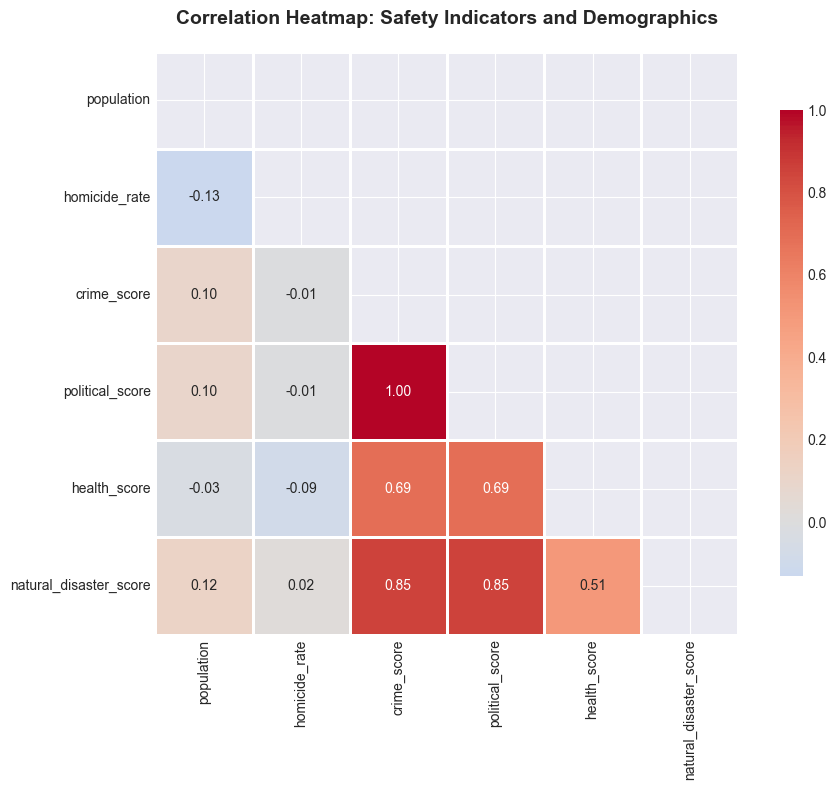

In [79]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_data, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Correlation Heatmap: Safety Indicators and Demographics', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 4.3 Regional Safety Comparison


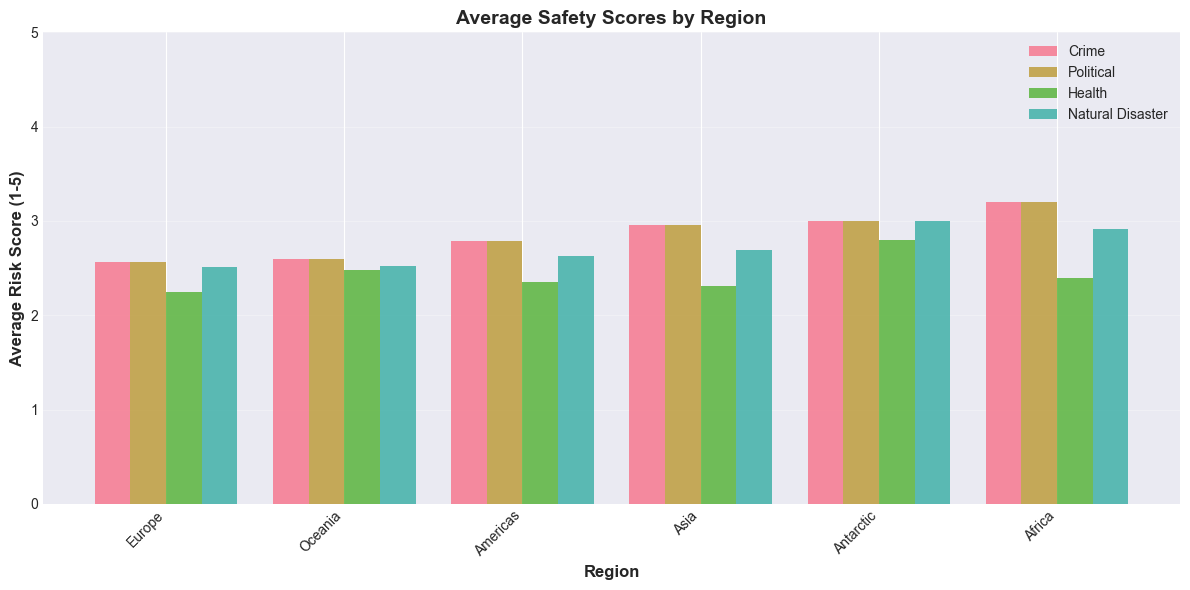

In [80]:
# Compare safety scores by region
regional_safety = df_final.groupby('region')[safety_cols].mean().sort_values('crime_score')

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(regional_safety))
width = 0.2

ax.bar(x - 1.5*width, regional_safety['crime_score'], width, label='Crime', alpha=0.8)
ax.bar(x - 0.5*width, regional_safety['political_score'], width, label='Political', alpha=0.8)
ax.bar(x + 0.5*width, regional_safety['health_score'], width, label='Health', alpha=0.8)
ax.bar(x + 1.5*width, regional_safety['natural_disaster_score'], width, label='Natural Disaster', alpha=0.8)

ax.set_xlabel('Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Risk Score (1-5)', fontsize=12, fontweight='bold')
ax.set_title('Average Safety Scores by Region', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(regional_safety.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 5)

plt.tight_layout()
plt.show()


### 4.4 Homicide Rate Distribution by Region


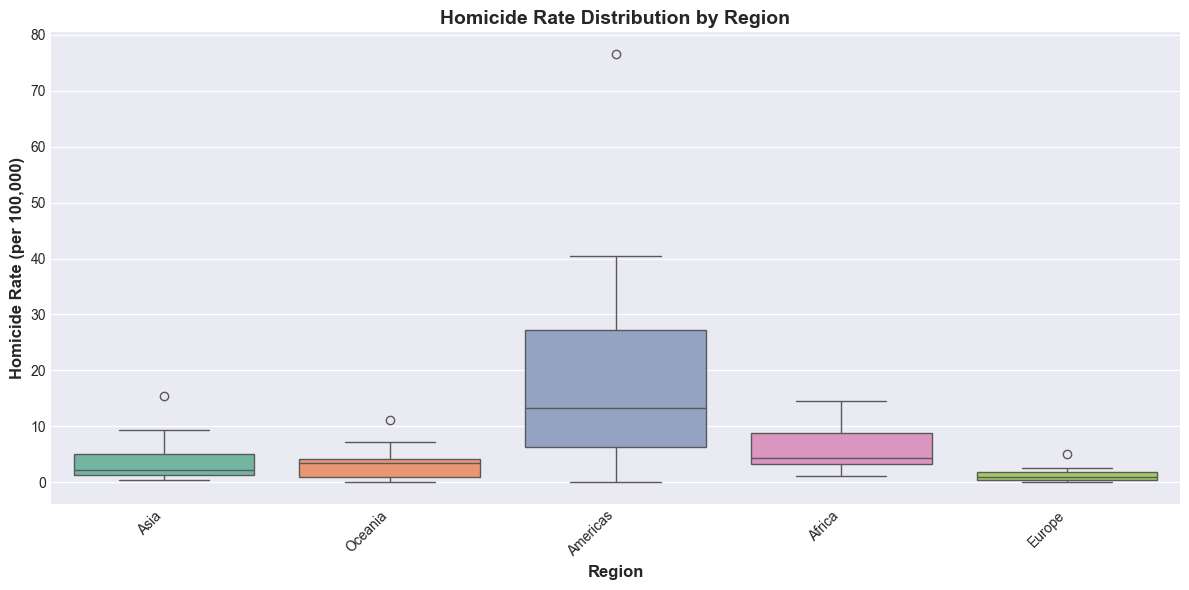

In [81]:
# Box plot of homicide rates by region
df_with_homicide_region = df_final[df_final['homicide_rate'].notna() & 
                                    (df_final['region'] != '')].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_with_homicide_region, x='region', y='homicide_rate', palette='Set2')
plt.xlabel('Region', fontsize=12, fontweight='bold')
plt.ylabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
plt.title('Homicide Rate Distribution by Region', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 4.5 Radar Chart: Comparing Multiple Countries


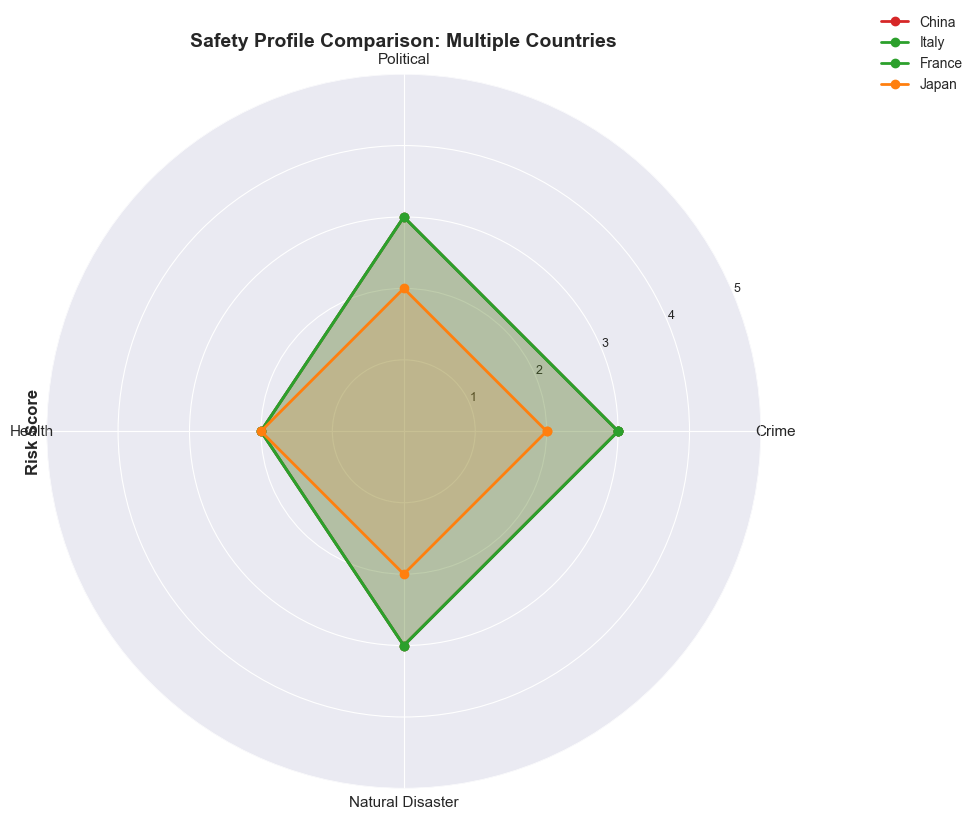

In [82]:
from math import pi

# Select countries to compare (example: France, Japan, Italy, China)
countries_to_compare = ['France', 'Japan', 'Italy', 'China']
df_compare = df_final[df_final['name'].isin(countries_to_compare)].copy()

# Prepare data for radar chart
categories = ['Crime', 'Political', 'Health', 'Natural Disaster']
N = len(categories)

# Calculate angles for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, row in df_compare.iterrows():
    values = [
        row['crime_score'],
        row['political_score'],
        row['health_score'],
        row['natural_disaster_score']
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['name'], color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], fontsize=9)
ax.set_ylabel('Risk Score', fontsize=12, fontweight='bold')
ax.set_title('Safety Profile Comparison: Multiple Countries', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()


### 4.6 Scatter Plot: Homicide Rate vs Crime Score


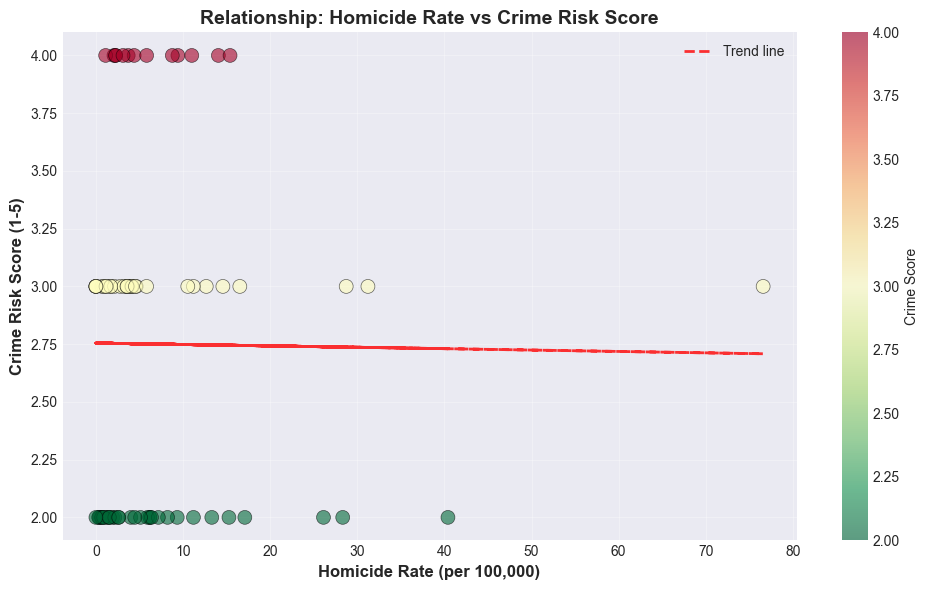


Correlation coefficient: -0.009


In [83]:
# Scatter plot comparing homicide rate with crime score
df_scatter = df_final[(df_final['homicide_rate'].notna()) & 
                       (df_final['crime_score'].notna())].copy()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_scatter['homicide_rate'], df_scatter['crime_score'], 
                     c=df_scatter['crime_score'], cmap='RdYlGn_r', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel('Homicide Rate (per 100,000)', fontsize=12, fontweight='bold')
plt.ylabel('Crime Risk Score (1-5)', fontsize=12, fontweight='bold')
plt.title('Relationship: Homicide Rate vs Crime Risk Score', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Crime Score')
plt.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df_scatter['homicide_rate'], df_scatter['crime_score'], 1)
p = np.poly1d(z)
plt.plot(df_scatter['homicide_rate'], p(df_scatter['homicide_rate']), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend line')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_scatter['homicide_rate'].corr(df_scatter['crime_score'])
print(f"\nCorrelation coefficient: {correlation:.3f}")


## 5. Key Findings and Insights


In [84]:
print("=== KEY FINDINGS ===\n")

# Finding 1: Countries with highest/lowest homicide rates
if len(df_with_homicide) > 0:
    highest = df_with_homicide.iloc[0]
    lowest = df_with_homicide.iloc[-1]
    print(f"1. Highest homicide rate: {highest['name']} ({highest['homicide_rate']:.2f} per 100,000)")
    print(f"   Lowest homicide rate: {lowest['name']} ({lowest['homicide_rate']:.2f} per 100,000)")

# Finding 2: Regional patterns
if len(regional_safety) > 0:
    safest_region = regional_safety['crime_score'].idxmin()
    riskiest_region = regional_safety['crime_score'].idxmax()
    print(f"\n2. Safest region (by crime score): {safest_region} ({regional_safety.loc[safest_region, 'crime_score']:.2f})")
    print(f"   Riskiest region (by crime score): {riskiest_region} ({regional_safety.loc[riskiest_region, 'crime_score']:.2f})")

# Finding 3: Correlation insights
if 'homicide_rate' in corr_data.columns and 'crime_score' in corr_data.index:
    corr_value = corr_data.loc['crime_score', 'homicide_rate']
    print(f"\n3. Correlation between homicide rate and crime score: {corr_value:.3f}")
    if abs(corr_value) > 0.5:
        print("   → Strong correlation detected")
    elif abs(corr_value) > 0.3:
        print("   → Moderate correlation detected")
    else:
        print("   → Weak correlation")

# Finding 4: Overall risk distribution
risk_dist = df_final['overall_risk'].value_counts()
print(f"\n4. Overall risk distribution:")
for risk_level, count in risk_dist.items():
    print(f"   {risk_level}: {count} countries ({count/len(df_final)*100:.1f}%)")


=== KEY FINDINGS ===

1. Highest homicide rate: Turks and Caicos Islands (76.58 per 100,000)
   Lowest homicide rate: San Marino (0.00 per 100,000)

2. Safest region (by crime score): Europe (2.57)
   Riskiest region (by crime score): Africa (3.20)

3. Correlation between homicide rate and crime score: -0.009
   → Weak correlation

4. Overall risk distribution:
   medium: 82 countries (32.5%)
   low: 81 countries (32.1%)
   high: 45 countries (17.9%)
   unknown: 44 countries (17.5%)


## 6. Export Analysis Results


In [85]:
# Export final merged dataset
df_final.to_csv('travel_safety_analysis.csv', index=False)
print("✓ Exported merged dataset to 'travel_safety_analysis.csv'")

# Export summary statistics
summary_stats = {
    'total_countries': len(df_final),
    'countries_with_homicide_data': int(df_final['homicide_rate'].notna().sum()),
    'countries_with_safety_data': int(df_final['crime_score'].notna().sum()),
    'mean_homicide_rate': float(df_final['homicide_rate'].mean()) if df_final['homicide_rate'].notna().any() else None,
    'mean_crime_score': float(df_final['crime_score'].mean()) if df_final['crime_score'].notna().any() else None,
    'regions_covered': int(df_final['region'].nunique())
}

with open('analysis_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("✓ Exported summary statistics to 'analysis_summary.json'")
print("\nSummary:")
for key, value in summary_stats.items():
    print(f"  {key}: {value}")


✓ Exported merged dataset to 'travel_safety_analysis.csv'
✓ Exported summary statistics to 'analysis_summary.json'

Summary:
  total_countries: 252
  countries_with_homicide_data: 76
  countries_with_safety_data: 252
  mean_homicide_rate: 7.573894736842105
  mean_crime_score: 2.857142857142857
  regions_covered: 6
